# imports

In [41]:
import pandas as pd
import numpy as np
import inflection
import math
import seaborn as sns
import datetime
import xgboost as xgb
import random
import warnings
import pickle
from matplotlib import pyplot as plt
from IPython.core.display import HTML
from IPython.display import Image
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

## helper functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    sns.set()
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


C:\Users\Lavin\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [3]:
def ml_error(model_name,y,yhat):
    import numpy as np
    mae = mean_absolute_error(y,yhat)
    mape = mean_absolute_percentage_error(y,yhat)
    rmse = np.sqrt(mean_squared_error(y,yhat))
    
    return pd.DataFrame({'Model Name':model_name,
                        'MAE':mae,
                        'MAPE':mape,
                        'RMSE':rmse},index=[0])

In [4]:
def cross_validation(x_training, kfold,model_name,model,verbose=False):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in list(range(kfold,0,-1)):
        if verbose:
            print(f"kfold: {k}")
        #Start and end date for validation
        val_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
        val_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)

        #filtering dataset
        training = x_training[x_training['date']< val_start_date]
        validation = x_training[(x_training['date']>= val_start_date)&(x_training['date']<= val_end_date)]

        # traini and validation dateset
        xtraining = training.drop(columns=['date','sales'])
        ytraining = training['sales']

        xvalidation = validation.drop(columns=['date','sales'])
        yvalidation = validation['sales']

        #model
        m = model.fit(xtraining, ytraining)


        # prediction
        yhat = m.predict(xvalidation)

        m_result = ml_error(model_name,np.expm1(yvalidation),np.expm1(yhat))
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])
        
    return pd.DataFrame({'Model name': model_name + " Cross_Val",
                                'MAE CROSS_VAL':np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                                'MAPE CROSS_VAL':np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                                'RMSE CROSS_VAL':np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str )},index=[0])

In [48]:
def mean_percentage_error( y, yhat ):
    return np.mean( ( y - yhat ) / y )

# load data

In [5]:
df7 = pd.read_csv('data/df6.csv',low_memory=False)

In [6]:
df7.head()

,store,promo,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,...,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos,day_of_week_sin,day_of_week_cos,sales,date
0,1,1,2,1,-0.170968,9,2008,0,31,2015,...,-0.5,-0.866025,-2.449294e-16,1.0,-0.568065,-0.822984,-0.974928,-0.222521,8.568456,2015-07-31
1,2,1,0,1,-0.283871,11,2007,1,13,2010,...,-0.5,-0.866025,-2.449294e-16,1.0,-0.568065,-0.822984,-0.974928,-0.222521,8.710125,2015-07-31
2,3,1,0,1,1.903226,12,2006,1,14,2011,...,-0.5,-0.866025,-2.449294e-16,1.0,-0.568065,-0.822984,-0.974928,-0.222521,9.025696,2015-07-31
3,4,1,2,3,-0.275806,9,2009,0,31,2015,...,-0.5,-0.866025,-2.449294e-16,1.0,-0.568065,-0.822984,-0.974928,-0.222521,9.546455,2015-07-31
4,5,1,0,1,4.448387,4,2015,0,31,2015,...,-0.5,-0.866025,-2.449294e-16,1.0,-0.568065,-0.822984,-0.974928,-0.222521,8.480944,2015-07-31


In [7]:
df7.shape

(844338, 23)

In [8]:
df7.dtypes

store                             int64
promo                             int64
store_type                        int64
assortment                        int64
competition_distance            float64
competition_open_since_month      int64
competition_open_since_year       int64
promo2                            int64
promo2_since_week                 int64
promo2_since_year                 int64
competition_time_month            int64
promo_time_week                 float64
competition_ time_month         float64
month_sin                       float64
month_cos                       float64
day_sin                         float64
day_cos                         float64
week_of_year_sin                float64
week_of_year_cos                float64
day_of_week_sin                 float64
day_of_week_cos                 float64
sales                           float64
date                             object
dtype: object

In [9]:
df7['date'] = pd.to_datetime(df7['date'])

# Split dataset

In [10]:
#train
x_train = df7[df7['date'] < '2015-06-19']
y_train = x_train['sales']

# test
x_test = df7[df7['date'] >= '2015-06-19']
y_test = x_test['sales']


cols_drop = ['date','sales']
x_train.drop(columns=cols_drop,inplace=True)
x_test.drop(columns=cols_drop,inplace=True)

C:\Users\Lavin\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


# Machine learning model

## Linear models

### Average Model

In [11]:
aux_1 = x_test.copy()
aux_1['sales'] = y_test.copy()

# prediction
aux_2 = aux_1[['store','sales']].groupby('store').mean().reset_index().rename(columns={'sales':'predictions'})
aux_1 = pd.merge(aux_1,aux_2,how='left',on='store')
yhat_baseline = aux_1['predictions']

#performace
baseline_result = ml_error('Average Model', np.expm1(y_test),np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800167,0.206441,1835.141019


### Linear regression Model

In [12]:
#model
lr = LinearRegression().fit(x_train,y_train)


# prediction
yhat_lr = lr.predict(x_test)

lr_result = ml_error("Linear Regression",np.expm1(y_test),np.expm1(yhat_lr))

In [13]:
lr_result 

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.651729,0.292898,2671.341479


### Linear Regression Regularized Model - Lasso

In [14]:
#model
ls = Lasso(alpha=0.001).fit(x_train,y_train)


# prediction
yhat_ls = ls.predict(x_test)

ls_result = ml_error("Linear Regression Lasso",np.expm1(y_test),np.expm1(yhat_ls))

In [15]:
ls_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression Lasso,1869.897925,0.292868,2677.289952


## Non-linear models

### Random Forest Regressor

In [16]:
#model
rf = RandomForestRegressor(n_estimators=100,n_jobs=-1,random_state=42).fit(x_train,y_train)
 
#prediction
yhat_rf = rf.predict(x_test)

#performace

rf_result = ml_error("Random Forest Regressor",np.expm1(y_test),np.expm1(yhat_rf))

In [17]:
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,678.227688,0.099938,1007.885324


### XGboost Regressor

In [18]:
#model
model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                             n_estimators=100,
                             eta=0.01,
                             max_depth=10,
                             subsample=0.7,
                             colsample_bytree=0.9).fit(x_train,y_train)

#prediction
yhat_xg = model_xgb.predict(x_test)

#performace

xgrf_result = ml_error("XGboost Regressor",np.expm1(y_test),np.expm1(yhat_xg))


In [19]:
xgrf_result

,Model Name,MAE,MAPE,RMSE
0,XGboost Regressor,6682.891559,0.949457,7330.477249


## Cross-validation

### Linear regression cross validation

In [20]:
model = LinearRegression()
lr = cross_validation(df7,5,"Linear Regression",model)
lr

,Model name,MAE CROSS_VAL,MAPE CROSS_VAL,RMSE CROSS_VAL
0,Linear Regression Cross_Val,1927.09 +/- 95.13,0.3 +/- 0.02,2724.09 +/- 178.86


### Linear Regression Regularized Model - Lasso cross validation

In [21]:
model = Lasso(alpha=0.001)
ls = cross_validation(df7,5,"Lasso",model)
ls

,Model name,MAE CROSS_VAL,MAPE CROSS_VAL,RMSE CROSS_VAL
0,Lasso Cross_Val,1925.39 +/- 98.72,0.3 +/- 0.01,2728.38 +/- 183.6


### Random Forest Regressor cross validation

In [22]:
model = RandomForestRegressor(n_estimators=100,n_jobs=-1,random_state=42)
rf = cross_validation(df7,5,"Random Regressor",model)

In [23]:
rf

### XGboost Regressor cross validation

In [24]:
model = xgb.XGBRegressor(objective='reg:squarederror',
                             n_estimators=100,
                             eta=0.01,
                             max_depth=10,
                             subsample=0.7,
                             colsample_bytree=0.9)

xbr = cross_validation(df7,5,"XGBoost Random Regressor",model)
xbr

# Model comparison

In [25]:
modelling_result = pd.concat([baseline_result,lr_result,ls_result,rf_result,xgrf_result])
modelling_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800167,0.206441,1835.141019
0,Linear Regression,1867.651729,0.292898,2671.341479
0,Linear Regression Lasso,1869.897925,0.292868,2677.289952
0,Random Forest Regressor,678.227688,0.099938,1007.885324
0,XGboost Regressor,6682.891559,0.949457,7330.477249


In [26]:
modelling_result_cross_val = pd.concat([lr,ls,rf,xbr])
modelling_result_cross_val

# Fine tuning

## Random Search

In [38]:
# param = {'n_est':[1500,1700,2500,3000,3500],
#         'eta':[0.01,0.1,0.3],
#         'max_d':[3,5,9],
#         'sub':[0.1,0.5,0,7],
#         'col_by':[0.3,0.7,0.9],
#         'min_ch':[3,8,15]}
# MAX_EVAL = 5

In [36]:
# warnings.filterwarnings('ignore')

In [39]:
# import random
# final_result = pd.DataFrame()

# for i in range( MAX_EVAL ):
#    # choose values for parameters randomly
#     hp = { k: random.sample( v, 1 )[0] for k, v in param.items() }
#     print( hp )
   
#    # model
#     model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
#                                  n_estimators=hp['n_est'], 
#                                  eta=hp['eta'], 
#                                  max_depth=hp['max_d'], 
#                                  subsample=hp['sub'],
#                                  colsample_bytree=hp['col_by'],
#                                  min_child_weight=hp['min_ch'] )

#    # performance
#     result = cross_validation(df7, 5, 'XGBoost Regressor', model_xgb, verbose=True )
#     final_result = pd.concat( [final_result, result] )
       
# final_result

{'n_est': 170, 'eta': 0.01, 'max_d': 9, 'sub': 0, 'col_by': 0.7, 'min_ch': 15}
kfold: 5
kfold: 4
kfold: 3
kfold: 2
kfold: 1
{'n_est': 150, 'eta': 0.3, 'max_d': 5, 'sub': 0, 'col_by': 0.9, 'min_ch': 15}
kfold: 5
kfold: 4
kfold: 3
kfold: 2
kfold: 1
{'n_est': 300, 'eta': 0.3, 'max_d': 9, 'sub': 0.1, 'col_by': 0.7, 'min_ch': 3}
kfold: 5
kfold: 4
kfold: 3
kfold: 2
kfold: 1
{'n_est': 350, 'eta': 0.1, 'max_d': 9, 'sub': 0, 'col_by': 0.3, 'min_ch': 15}
kfold: 5
kfold: 4
kfold: 3
kfold: 2
kfold: 1
{'n_est': 350, 'eta': 0.3, 'max_d': 3, 'sub': 7, 'col_by': 0.3, 'min_ch': 8}
kfold: 5


XGBoostError: value 7 for Parameter subsample exceed bound [0,1]
subsample: Row subsample ratio of training instance.

# Final Model

In [42]:
param_tuned = {
    'n_estimators': 3000,
    'eta': 0.03,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 3 
        }

In [44]:
# # model
# model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
#                                     n_estimators=param_tuned['n_estimators'], 
#                                     eta=param_tuned['eta'], 
#                                     max_depth=param_tuned['max_depth'], 
#                                     subsample=param_tuned['subsample'],
#                                     colsample_bytree=param_tuned['colsample_bytree'],
#                                     min_child_weight=param_tuned['min_child_weight'] ).fit( x_train, y_train )

# # prediction
# yhat_xgb_tuned = model_xgb_tuned.predict( x_test )

# # performance
# xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
# xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,759.253543,0.115643,1083.27381


In [47]:
#pickle.dump(model_xgb_tuned,open('model/model_rossman_xgb.pkl','wb'))

**MPE**

In [49]:
mpe = mean_percentage_error(np.expm1( y_test ), np.expm1( yhat_xgb_tuned ))
mpe

-0.02435192019278294

In [106]:
#np.savetxt('data/predictions_xgb_3000.csv',yhat_xgb_tuned,delimiter=',')

# Tradução e interpretação do erro

In [53]:
df8 = df7[df7['date'] >= '2015-06-19']

In [57]:
df8['sales'] = np.expm1(df8['sales'])
df8['predictions'] = np.expm1(yhat_xgb_tuned)

In [77]:
# sum of predictions
df8_a = df8[['store','predictions']].groupby('store').sum().reset_index()

#MAE and MAPE
df8_b = df8[['store','sales','predictions']].groupby('store').apply(lambda x:mean_absolute_error(x['sales'],x['predictions'])).reset_index().rename({0:'MAE'},axis=1)
df8_c = df8[['store','sales','predictions']].groupby('store').apply(lambda x:mean_absolute_percentage_error(x['sales'],x['predictions'])).reset_index().rename({0:'MAPE'},axis=1)

df8_a['MAE'] = df8_b['MAE']
df8_a['MAPE'] = df8_c['MAPE']

# scenario
df8_a['worst_scenario'] = df8_a['predictions'] - df8_a['MAE']
df8_a['best_scenario'] = df8_a['predictions'] + df8_a['MAE']

df8_a = df8_a[['store', 'predictions', 'worst_scenario','best_scenario', 'MAE', 'MAPE']]

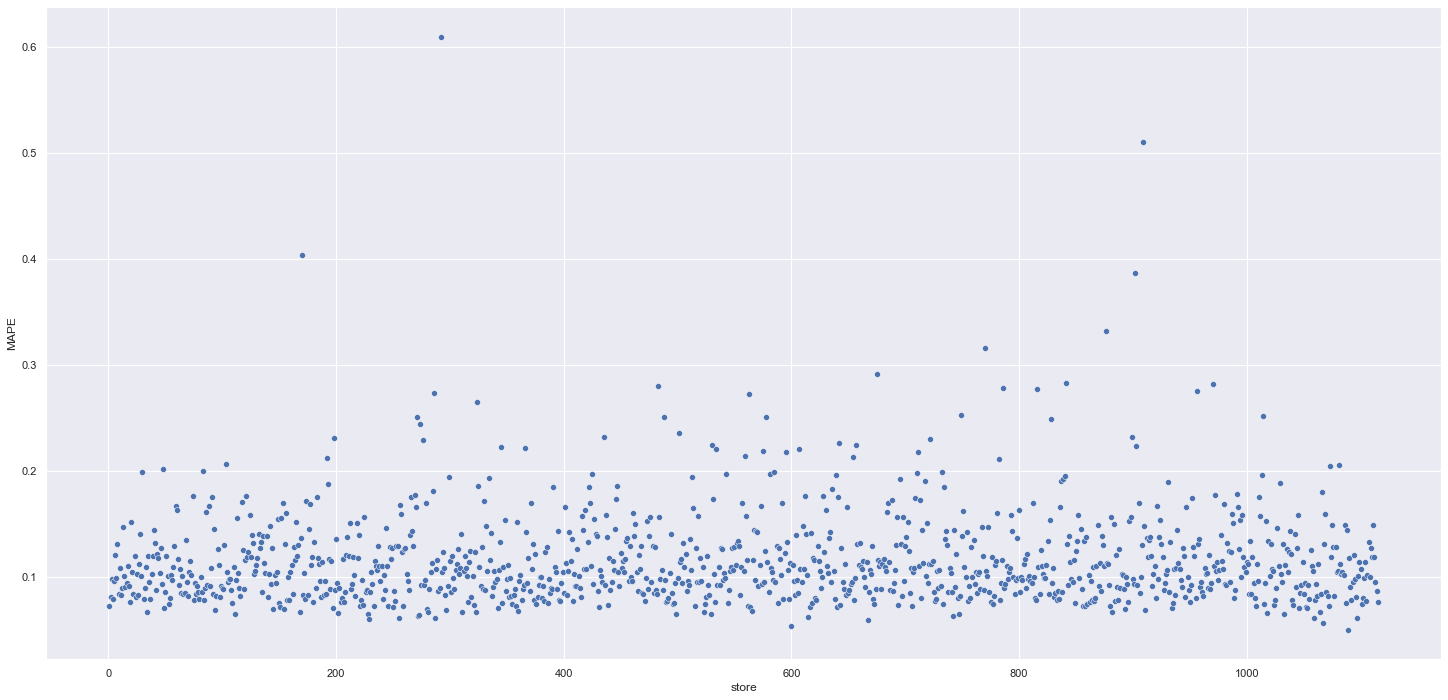

In [86]:
sns.scatterplot(x='store',y='MAPE',data=df8_a);

## Total performace

In [95]:
df8_d = df8_a[['predictions', 'worst_scenario','best_scenario']].apply(lambda x:np.sum(x),axis=0).reset_index().rename({'index':'scenarios',0:'values'},axis=1)
df8_d['values'] = df8_d['values'].map('R$ {:,.2f}'.format)
df8_d

,scenarios,values
0,predictions,"R$ 288,028,928.00"
1,worst_scenario,"R$ 287,179,218.78"
2,best_scenario,"R$ 288,878,591.11"


In [96]:
df8['error'] = df8['sales'] - df8['predictions']
df8['error_rate'] = df8['predictions']/df8['sales']

<AxesSubplot:xlabel='predictions', ylabel='error'>

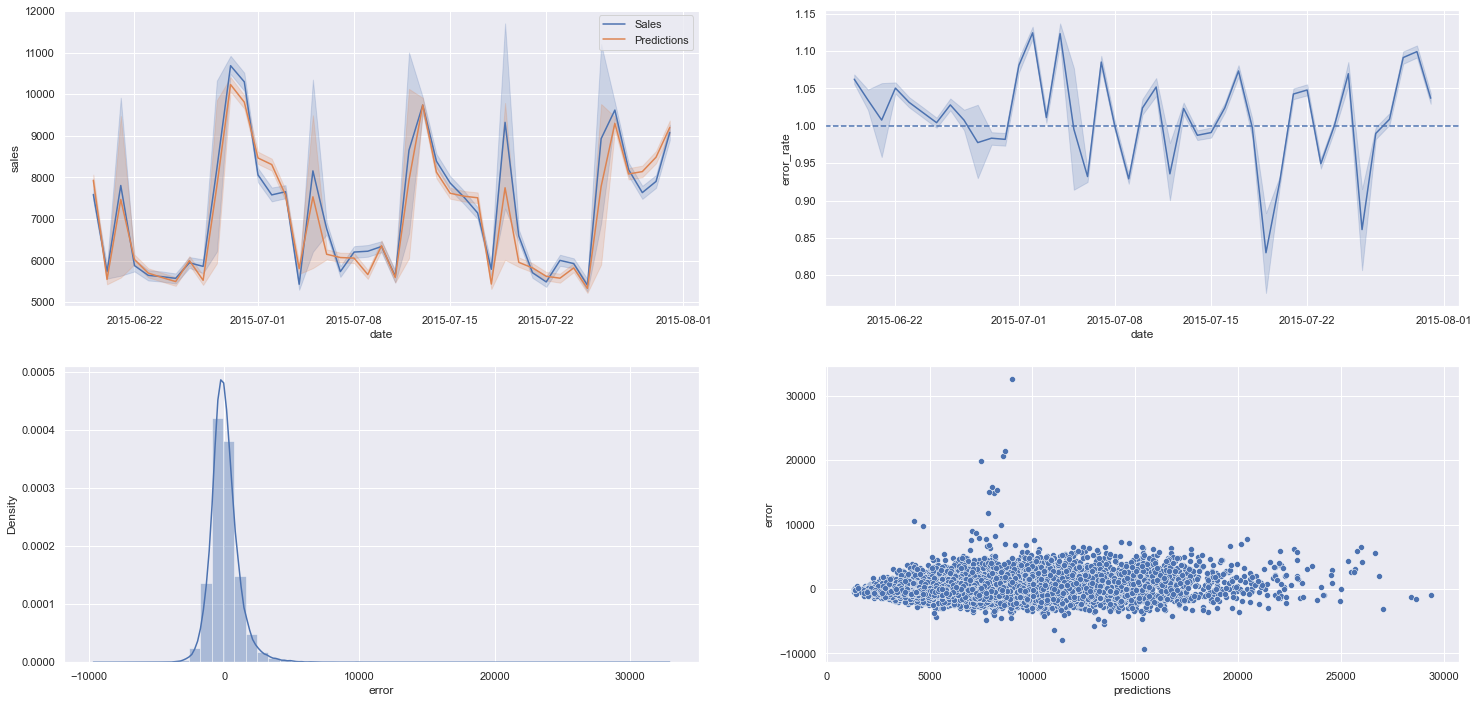

In [105]:
plt.subplot(2,2,1)
sns.lineplot(x='date',y='sales',data=df8,label='Sales')
sns.lineplot(x='date',y='predictions',data=df8,label='Predictions')

plt.subplot(2,2,2)
sns.lineplot(x='date',y='error_rate',data=df8)
plt.axhline(1,linestyle='--')
plt.subplot(2,2,3)
sns.distplot(df8['error'])
plt.subplot(2,2,4)
sns.scatterplot(x='predictions',y='error',data=df8)